# PyTorch Simple MLP Example

The Iris data sets consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy.ndarray

The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

plt.style.use('ggplot')
%matplotlib inline

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim



cuda = torch.cuda.is_available()
num_workers = 2 if cuda else 0
device = torch.device("cuda" if cuda else "cpu")


## Data Preperation
To prepare the data, we will use a StandardScaler to remove the mean and scale the features to unit variance. Finally we want to perform a train test split to compare our results later on.

In [4]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

# Datasets & Dataloaders
Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

## Define Dataset
We need to define the structure of our training and testing set, inorder to feed it into the DataLoader.

In [32]:
class MyDataset(Dataset):
  def __init__(self, train_x, train_y):
    self.length = 0

    self.X = train_x
    self.Y = train_y
    self.length = len(self.X)




  def __getitem__(self, index):
    
    x = self.X[index]
    y = self.Y[index]
    return x.astype("float32"), y.astype("long")



  def __len__(self):
    return self.length


## Dataloader
Using the torch.utils.data DataLoader, we shuffle the data and set the batch size to be 32

In [33]:
train_dataset = MyDataset(X_train, y_train)
train_loader_args = dict(shuffle = True, batch_size = 32, num_workers = num_workers, pin_memory = True, drop_last = False) if cuda else dict(shuffle = True, batch_size = 16)
train_loader = DataLoader(train_dataset, **train_loader_args)

In [34]:
test_dataset = MyDataset(X_test, y_test)
test_loader_args = dict(shuffle = False, batch_size = 32, num_workers = num_workers, pin_memory = True, drop_last = False) if cuda else dict(shuffle = False, batch_size = 16)
test_loader = DataLoader(test_dataset, **test_loader_args)

# Define our Neural Network Model 
We define our model using the torch.nn.Module class

In [40]:
# SIMPLE MODEL DEFINITION
class Simple_MLP(nn.Module):
    def __init__(self, input_dim):
        super(Simple_MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, 96)
        self.layer2 = nn.Linear(96, 64)
        self.layer3 = nn.Linear(64, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))

        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

# Create the model and define the Loss and Optimizer
We create an instance of our Simple_MLP model by passing it a list of layer sizes. The input layer contains 28*28 = 784 neurons. We define a single hidden layer of size 256, and our output will be the class probabilities for each of the 10 digits (0-9). 

Since this is a classification task, we will use Cross Entropy Loss. We define our criterion using the torch.nn.CrossEntropyLoss.

In order to train our network, we use the torch.optim.SGD optimizer.

In [42]:
model = Simple_MLP(X_train.shape[1]) #4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)
model.to(device)
print(model)

Simple_MLP(
  (layer1): Linear(in_features=4, out_features=96, bias=True)
  (layer2): Linear(in_features=96, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=3, bias=True)
)


In [37]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

In [38]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            predicted = torch.argmax(outputs, dim=1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc


# Start Training

In [43]:
n_epochs = 10
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_model(model, test_loader, criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    print('='*20)

Training Loss:  1.0568784475326538 Time:  0.01980280876159668 s
Testing Loss:  1.0096579790115356
Testing Accuracy:  73.33333333333333 %
Training Loss:  0.9713124707341194 Time:  0.012858152389526367 s
Testing Loss:  0.930728018283844
Testing Accuracy:  73.33333333333333 %
Training Loss:  0.9098915755748749 Time:  0.016101837158203125 s
Testing Loss:  0.8509744107723236
Testing Accuracy:  73.33333333333333 %
Training Loss:  0.8418034389615059 Time:  0.010380744934082031 s
Testing Loss:  0.7945247292518616
Testing Accuracy:  76.66666666666667 %
Training Loss:  0.7975567653775215 Time:  0.0192263126373291 s
Testing Loss:  0.7604177892208099
Testing Accuracy:  80.0 %
Training Loss:  0.7658775299787521 Time:  0.012276411056518555 s
Testing Loss:  0.7348880469799042
Testing Accuracy:  86.66666666666667 %
Training Loss:  0.7396701946854591 Time:  0.01060342788696289 s
Testing Loss:  0.7179379165172577
Testing Accuracy:  86.66666666666667 %
Training Loss:  0.717106893658638 Time:  0.019183397

## Visualize Training Logs

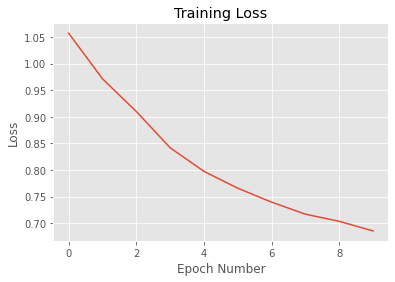

In [44]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Train_loss)

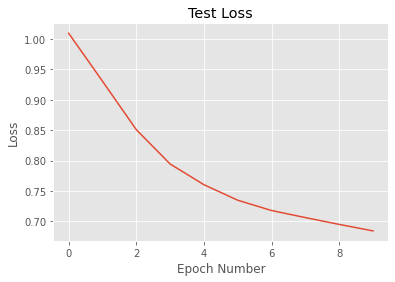

In [45]:
plt.title('Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Test_loss)

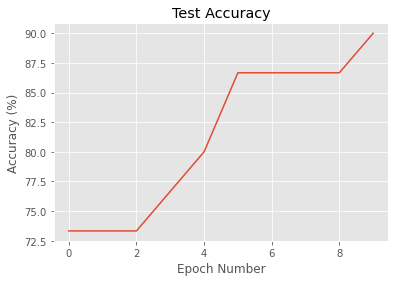

In [46]:
plt.title('Test Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(Test_acc)